In [42]:
import logging
import time
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
from pyspark import SparkConf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StructType, StructField, LongType, StringType, ArrayType
from graphframes import GraphFrame

# --- Initialize Logger ---
# Set up basic logging (adjust level and format as needed)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Spark Configuration (assuming you have this configured from previous steps) ---
conf = SparkConf() \
    .setAppName("SARL_Spark_LPA_Partitioning") \
    .setMaster("local[*]") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.instances", "6") \
    .set("spark.executor.cores", "6") \
    .set("spark.memory.offHeap.enabled", "true") \
    .set("spark.memory.offHeap.size", "3g") \
    .set("spark.sql.shuffle.partitions", "200") \
    .set("spark.executor.extraJavaOptions", "-Xss4m") \
    .set("spark.driver.extraJavaOptions", "-Xss4m") \
    .set("spark.executor.memoryOverhead", "6g") \
    .set("spark.driver.memoryOverhead", "6g") \
    .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .set("spark.kryoserializer.buffer.max", "512m") \
    .set("spark.memory.fraction", "0.6") \
    .set("spark.memory.storageFraction", "0.5") \
    .set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext # Get SparkContext for log level setting
sc.setLogLevel("INFO") # Set Spark's own logging level
logger.info(f"Spark Version: {spark.version}")
logger.info(f"Spark Driver Memory: {spark.conf.get('spark.driver.memory')}")
logger.info(f"Spark Executor Memory: {spark.conf.get('spark.executor.memory')}")
logger.info(f"Spark Executor Cores: {spark.conf.get('spark.executor.cores')}")

2025-06-03 08:18:20,023 - INFO - Spark Version: 3.4.0
2025-06-03 08:18:20,025 - INFO - Spark Driver Memory: 16g
2025-06-03 08:18:20,028 - INFO - Spark Executor Memory: 16g
2025-06-03 08:18:20,029 - INFO - Spark Executor Cores: 6


In [43]:
# --- Step 0: Load and Preprocess Data (Optimized) ---
logger.info("Step 0: Loading and Preprocessing Data (Optimized)...")
start_time = time.time()

transaction_file_path = 'sarl-spark/data/processed/transactional_data_zscore.csv'

# Load the raw text file into an RDD
raw_lines_rdd = sc.textFile(transaction_file_path)

# Get the header row. This action will cause Spark to read the first line.
header = raw_lines_rdd.first()
# Filter out the header row from the RDD, then proceed with mapping and filtering
transactions_rdd = raw_lines_rdd.filter(lambda line: line != header) \
                                 .map(lambda line: [item.strip() for item in line.strip().split(',') if item.strip()]) \
                                 .filter(lambda transaction: len(transaction) > 0)

# Convert to DataFrame
transactions_df = spark.createDataFrame(transactions_rdd, ArrayType(StringType()))
transactions_df = transactions_df.withColumnRenamed("value", "items") # Renames the default column 'value' to 'items'
transactions_df.cache()
transactions_df.show(5, truncate=False) # Keep this for initial data check
logger.info(f"Total transactions loaded (after removing header): {transactions_df.count()}")
transactions_df = transactions_df.filter(F.size("items") < 1000)
logger.info(f"Total transactions after removing transactions with more than 5000 items: {transactions_df.count()}")

logger.info(f"Time taken for data loading and preprocessing: {time.time() - start_time:.2f} seconds")

2025-06-03 08:18:20,040 - INFO - Step 0: Loading and Preprocessing Data (Optimized)...


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2025-06-03 08:18:22,408 - INFO - Total transactions loaded (after removing header): 2302
2025-06-03 08:18:22,455 - INFO - Total transactions after removing transactions with more than 5000 items: 1570
2025-06-03 08:18:22,456 - INFO - Time taken for data loading and preprocessing: 2.41 seconds


In [44]:
# Check the schema of transactions_df
transactions_df.printSchema()

# Filter transactions containing "normal"
normal_transactions = transactions_df.filter(
    F.array_contains(F.col("items"), "normal")
)

# Count and show a sample
count = normal_transactions.count()
print(f"Found {count} transactions containing 'normal'")

# Show some examples with all available columns
normal_transactions.show(10, truncate=False)

# If you want to see more rows
normal_transactions.show(20, truncate=100)

root
 |-- items: array (nullable = true)
 |    |-- element: string (containsNull = true)

Found 168 transactions containing 'normal'
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Total number of transactions: 1570


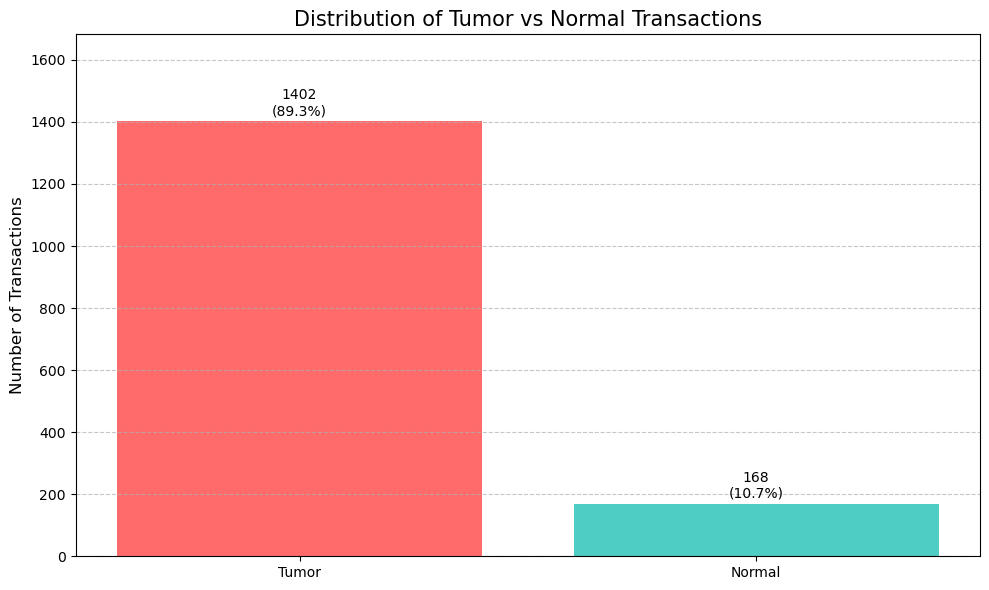

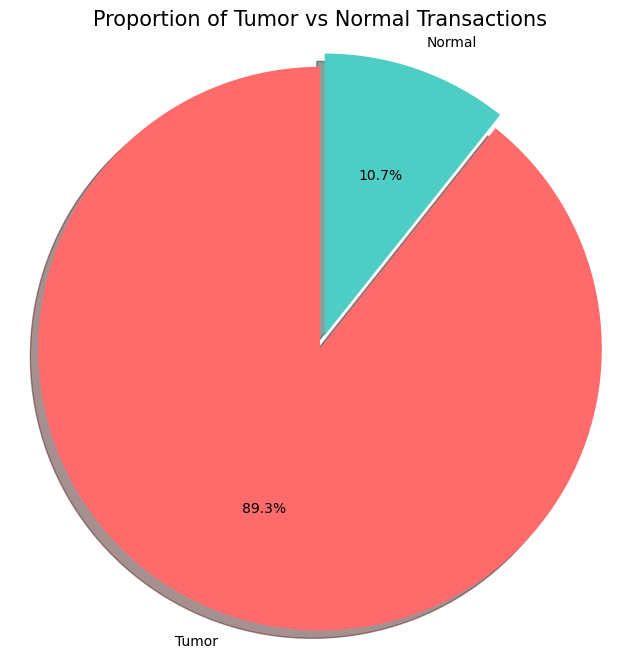

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Get counts directly from the data
tumor_count = transactions_df.filter(
    F.array_contains(F.col("items"), "tumor")
).count()

normal_count = transactions_df.filter(
    F.array_contains(F.col("items"), "normal")
).count()

# Data
categories = ['Tumor', 'Normal']
counts = [tumor_count, normal_count]

# Calculate total transactions
total_transactions = transactions_df.count()
print(f"Total number of transactions: {total_transactions}")

# Create figure
plt.figure(figsize=(10, 6))

# Bar chart
bars = plt.bar(categories, counts, color=['#FF6B6B', '#4ECDC4'])

# Add count and percentage labels on top of bars
for bar, count in zip(bars, counts):
    percentage = (count / total_transactions) * 100
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 20,
        f'{count}\n({percentage:.1f}%)',
        ha='center'
    )

# Add title and labels
plt.title('Distribution of Tumor vs Normal Transactions', fontsize=15)
plt.ylabel('Number of Transactions', fontsize=12)
plt.ylim(0, max(counts) * 1.2)  # Add some space for the labels

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Pie chart for proportion
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=categories,
    autopct='%1.1f%%',
    colors=['#FF6B6B', '#4ECDC4'],
    explode=(0.05, 0),  # Slightly explode the tumor slice
    shadow=True,
    startangle=90
)
plt.title('Proportion of Tumor vs Normal Transactions', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [46]:
# --- SARL Heuristic Parameters ---
MIN_SUPPORT_PERCENTAGE = 0.01 # Example: 10% minsup as in the paper's example
NUM_PARTITIONS_K = 4 # Example: k=4 as in the paper's experiments for LPA (Note: LPA doesn't guarantee exactly k partitions)
MIN_CONFIDENCE = 0.7 # Example: 70% minconf

# Calculate actual min_support count for filtering 1- and 2-itemsets
total_transactions = transactions_df.count()
min_support_count = int(total_transactions * MIN_SUPPORT_PERCENTAGE)
min_support_fraction = MIN_SUPPORT_PERCENTAGE # FPGrowth expects a fraction

logger.info(f"SARL Parameters: min_support_percentage={MIN_SUPPORT_PERCENTAGE}, num_partitions_k={NUM_PARTITIONS_K}, min_confidence={MIN_CONFIDENCE}")
logger.info(f"Calculated min_support_count: {min_support_count}")

# --- Step 1: Find Frequent One-Itemsets ---
logger.info("Step 1: Finding Frequent One-Itemsets...")
start_time = time.time()

# Explode the 'items' array to get individual items, then group by item and count their occurrences.
frequent_1_itemsets_df = transactions_df.select(F.explode("items").alias("item")) \
                                        .groupBy("item") \
                                        .count() \
                                        .filter(F.col("count") >= min_support_count) \
                                        .withColumn("items", F.array(F.col("item"))) \
                                        .select("items", "count")
frequent_1_itemsets_df.cache() # Cache for later use
logger.info(f"Found {frequent_1_itemsets_df.count()} frequent 1-itemsets.")
frequent_1_itemsets_df.orderBy("count", ascending=False).show(5, truncate=False)
logger.info(f"Time taken for Step 1: {time.time() - start_time:.2f} seconds")

2025-06-03 08:18:23,233 - INFO - SARL Parameters: min_support_percentage=0.01, num_partitions_k=4, min_confidence=0.7
2025-06-03 08:18:23,234 - INFO - Calculated min_support_count: 15
2025-06-03 08:18:23,234 - INFO - Step 1: Finding Frequent One-Itemsets...
2025-06-03 08:18:23,887 - INFO - Found 26576 frequent 1-itemsets.
2025-06-03 08:18:24,156 - INFO - Time taken for Step 1: 0.92 seconds


+----------+-----+
|items     |count|
+----------+-----+
|[tumor]   |1402 |
|[normal]  |168  |
|[+UGT2B28]|118  |
|[+SLC26A3]|117  |
|[+NXPH1]  |114  |
+----------+-----+
only showing top 5 rows



In [47]:
# --- Step 2: Find Frequent Two-Itemsets and Prepare IAG Edges ---
logger.info("Step 2: Finding Frequent Two-Itemsets and Preparing IAG Edges...")
start_time = time.time()

# Define cache path for frequent 2-itemsets
cache_dir = "tmp/spark-cache"
frequent_2_itemsets_cache_path = f"{cache_dir}/frequent_2_itemsets_{min_support_fraction}"

# Check if cached result exists with the same min_support
import os
cached_result_exists = False

try:
    # Try to access the cache metadata file that stores the min_support value
    metadata_path = f"{frequent_2_itemsets_cache_path}/_metadata"
    cached_result_exists = os.path.exists(metadata_path)

    if cached_result_exists:
        logger.info(f"Found cached frequent 2-itemsets with min_support={min_support_fraction}")
        # Load from cache
        frequent_2_itemsets_df = spark.read.parquet(frequent_2_itemsets_cache_path)
        frequent_2_itemsets_df.cache()  # Cache in memory for faster access
        logger.info(f"Loaded {frequent_2_itemsets_df.count()} frequent 2-itemsets from cache.")
        frequent_2_itemsets_df.show(5, truncate=False)
except Exception as e:
    logger.warning(f"Error checking or loading cache: {str(e)}")
    cached_result_exists = False

# If no cached result, compute the frequent 2-itemsets
if not cached_result_exists:
    logger.info("Computing frequent 2-itemsets (no cache found or cache invalid)...")

    # Create a DataFrame with individual items and their transaction IDs
    item_df = transactions_df.withColumn(
        "transaction_id", F.monotonically_increasing_id()
    ).select(
        F.col("transaction_id"),
        F.explode("items").alias("item")
    )
    item_df.cache()  # Cache item_df as it's used in the join

    # Self-join to create pairs (more efficient than UDF)
    pairs_df = item_df.alias("a").join(
        item_df.alias("b"),
        (F.col("a.transaction_id") == F.col("b.transaction_id")) &
        (F.col("a.item") < F.col("b.item"))  # Ensures unique pairs and consistent order
    ).select(
        F.col("a.item").alias("src"),
        F.col("b.item").alias("dst")
    )

    # Count frequencies and filter by min_support
    frequent_2_itemsets_df = pairs_df.groupBy("src", "dst") \
        .count() \
        .filter(F.col("count") >= min_support_count) \
        .withColumnRenamed("count", "weight")  # Rename count to weight for IAG

    # Save to cache
    try:
        # Ensure directory exists
        os.makedirs(cache_dir, exist_ok=True)

        # Save the DataFrame to disk
        logger.info(f"Saving frequent 2-itemsets to cache: {frequent_2_itemsets_cache_path}")
        frequent_2_itemsets_df.write.mode("overwrite").parquet(frequent_2_itemsets_cache_path)

        # Also save min_support as a small text file for future reference
        with open(f"{cache_dir}/frequent_2_itemsets_{min_support_fraction}_params.txt", "w") as f:
            f.write(f"min_support_fraction={min_support_fraction}\n")
            f.write(f"min_support_count={min_support_count}\n")
            f.write(f"timestamp={time.time()}\n")
    except Exception as e:
        logger.warning(f"Error saving cache: {str(e)}")

    # Clean up
    item_df.unpersist()

    # Cache in memory for later use
    frequent_2_itemsets_df.cache()
    logger.info(f"Found {frequent_2_itemsets_df.count()} frequent 2-itemsets (IAG edges).")
    frequent_2_itemsets_df.show(5, truncate=False)

logger.info(f"Time taken for Step 2: {time.time() - start_time:.2f} seconds")

2025-06-03 08:18:24,175 - INFO - Step 2: Finding Frequent Two-Itemsets and Preparing IAG Edges...
2025-06-03 08:18:24,180 - INFO - Computing frequent 2-itemsets (no cache found or cache invalid)...
2025-06-03 08:18:24,226 - INFO - Saving frequent 2-itemsets to cache: tmp/spark-cache/frequent_2_itemsets_0.01
2025-06-03 08:24:42,609 - INFO - Found 84215 frequent 2-itemsets (IAG edges).
2025-06-03 08:24:42,657 - INFO - Time taken for Step 2: 378.48 seconds


+-------+------+------+
|src    |dst   |weight|
+-------+------+------+
|+TAC1  |+TESC |18    |
|+FAM13C|+PGM5 |18    |
|+MYH11 |+PLAC9|17    |
|+LMOD1 |+PLAC9|16    |
|+GNG11 |+PAMR1|15    |
+-------+------+------+
only showing top 5 rows



In [48]:
# --- Step 3: Construct IAG and Partition using Label Propagation Algorithm (LPA) ---
logger.info("Step 3: Constructing IAG and Partitioning using LPA...")
start_time = time.time()

# Define cache path for LPA results
cache_dir = "tmp/spark-cache"
lpa_result_cache_path = f"{cache_dir}/lpa_result_{min_support_fraction}"

# Check if cached result exists with the same min_support
import os
cached_lpa_exists = False

try:
    # Try to access the cache metadata file
    metadata_path = f"{lpa_result_cache_path}/_metadata"
    cached_lpa_exists = os.path.exists(metadata_path)

    if cached_lpa_exists:
        logger.info(f"Found cached LPA results with min_support={min_support_fraction}")
        # Load from cache
        lpa_result = spark.read.parquet(lpa_result_cache_path)
        lpa_result.cache()  # Cache in memory for faster access

        # Get the number of actual partitions found by LPA
        num_actual_partitions = lpa_result.select("label").distinct().count()
        logger.info(f"Loaded LPA results with {num_actual_partitions} communities from cache.")
        lpa_result.show(5)
except Exception as e:
    logger.warning(f"Error checking or loading LPA cache: {str(e)}")
    cached_lpa_exists = False

# If no cached result, compute the LPA partitioning
if not cached_lpa_exists:
    logger.info("Computing LPA partitioning (no cache found or cache invalid)...")

    # Create vertices DataFrame for GraphFrames. 'id' column is mandatory.
    # All unique items found in frequent 1-itemsets are considered vertices.
    unique_items_df = frequent_1_itemsets_df.select(F.col("items")[0].alias("id")).distinct()
    unique_items_df.cache()
    logger.info(f"Found {unique_items_df.count()} unique items for IAG vertices.")
    unique_items_df.show(5)

    # Create GraphFrame object.
    # The 'weight' column in edges_df (frequent_2_itemsets_df) will be used by LPA to influence propagation.
    try:
        iag_graph = GraphFrame(unique_items_df, frequent_2_itemsets_df)
        iag_graph.cache() # Cache the GraphFrame for performance
        logger.info(f"IAG created with {iag_graph.vertices.count()} vertices and {iag_graph.edges.count()} edges.")

        # Check graph density to decide on partitioning approach
        vertex_count = iag_graph.vertices.count()
        edge_count = iag_graph.edges.count()
        graph_density = (2.0 * edge_count) / (vertex_count * (vertex_count - 1)) if vertex_count > 1 else 0
        logger.info(f"Graph density: {graph_density:.8f}")

        # If graph is very sparse, use connected components instead of LPA
        if graph_density < 0.0001:  # Threshold can be adjusted
            logger.info("Graph is very sparse. Using connected components instead of LPA.")
            connected_result = iag_graph.connectedComponents()
            connected_result.cache()

            # Count components and their sizes
            component_sizes = connected_result.groupBy("component").count().orderBy("count", ascending=False)
            component_count = component_sizes.count()
            logger.info(f"Found {component_count} connected components")

            # Show the largest components
            logger.info("Largest connected components:")
            component_sizes.show(10)

            # If there are too many tiny components, merge small ones
            if component_count > 100:  # Threshold can be adjusted
                logger.info("Too many small components. Merging small components...")

                # Identify components to keep separate (larger ones)
                large_components = component_sizes.filter(F.col("count") >= 3).select("component").collect()
                large_component_ids = [row.component for row in large_components]

                # Assign a new label: either keep original component or assign to "small_component"
                lpa_result = connected_result.withColumn(
                    "label",
                    F.when(F.col("component").isin(large_component_ids), F.col("component"))
                     .otherwise(F.lit("small_components"))
                )
            else:
                # Just rename the column for consistency
                lpa_result = connected_result.withColumnRenamed("component", "label")
        else:
            # Use Label Propagation Algorithm for denser graphs
            logger.info("Using Label Propagation Algorithm...")
            lpa_result = iag_graph.labelPropagation(maxIter=10)
            lpa_result.cache()

        logger.info("Partitioning completed. Showing first 5 items with their assigned labels:")
        lpa_result.show(5)

        # Get the number of actual partitions found
        num_actual_partitions = lpa_result.select("label").distinct().count()
        logger.info(f"Found {num_actual_partitions} partitions.")

        # Show partition distribution
        logger.info("Partition size distribution:")
        lpa_result.groupBy("label").count().orderBy("count", ascending=False).show(10)

        # Save to cache
        try:
            # Ensure directory exists
            os.makedirs(cache_dir, exist_ok=True)

            # Save the DataFrame to disk
            logger.info(f"Saving partitioning results to cache: {lpa_result_cache_path}")
            lpa_result.write.mode("overwrite").parquet(lpa_result_cache_path)

            # Also save parameters as a small text file for future reference
            with open(f"{cache_dir}/lpa_result_{min_support_fraction}_params.txt", "w") as f:
                f.write(f"min_support_fraction={min_support_fraction}\n")
                f.write(f"min_support_count={min_support_count}\n")
                f.write(f"timestamp={time.time()}\n")
        except Exception as e:
            logger.warning(f"Error saving cache: {str(e)}")

        # Clean up
        iag_graph.unpersist()
        unique_items_df.unpersist()

    except Exception as e:
        logger.error(f"Error during graph partitioning: {e}. Ensure GraphFrames is correctly installed and Spark is configured for it.")
        # In a production environment, you might implement a fallback strategy or exit.
        # For this example, we'll create an empty lpa_result to avoid further errors.
        lpa_result = None
        num_actual_partitions = 0
else:
    # If we loaded from cache, we don't need to create these
    unique_items_df = None
    iag_graph = None

logger.info(f"Time taken for Step 3: {time.time() - start_time:.2f} seconds")

2025-06-03 08:24:42,688 - INFO - Step 3: Constructing IAG and Partitioning using LPA...
2025-06-03 08:24:42,691 - INFO - Computing LPA partitioning (no cache found or cache invalid)...
2025-06-03 08:24:50,890 - INFO - Found 26576 unique items for IAG vertices.


+----------+
|        id|
+----------+
|   +ZNF765|
|+LOC340090|
|   +NDUFA3|
|     +TFPT|
|  +ZFAND2B|
+----------+
only showing top 5 rows



2025-06-03 08:24:51,683 - INFO - IAG created with 26576 vertices and 84215 edges.
2025-06-03 08:24:52,298 - INFO - Graph density: 0.00023848
2025-06-03 08:24:52,299 - INFO - Using Label Propagation Algorithm...
/usr/local/spark/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
2025-06-03 08:43:30,466 - INFO - Partitioning completed. Showing first 5 items with their assigned labels:


+--------+------------+
|      id|       label|
+--------+------------+
|  +GNB1L|901943132251|
|  +HOXC9|901943132251|
|+PRELID1|901943132251|
|  +FOXP2|901943132251|
| +TAS2R5|901943132251|
+--------+------------+
only showing top 5 rows



2025-06-03 08:43:34,279 - INFO - Found 2070 partitions.
2025-06-03 08:43:34,281 - INFO - Partition size distribution:
2025-06-03 08:43:35,073 - INFO - Saving partitioning results to cache: tmp/spark-cache/lpa_result_0.01


+------------+-----+
|       label|count|
+------------+-----+
|901943132251|21057|
|910533066822|  627|
|755914244130|  586|
|824633720905|  489|
|747324309564|  330|
|644245094441|  270|
|979252543550|  158|
|858993459243|  126|
|438086664195|   64|
|816043786333|   64|
+------------+-----+
only showing top 10 rows



2025-06-03 08:43:36,705 - INFO - Time taken for Step 3: 1134.02 seconds


In [49]:
# --- Step 4: Partitioning Transactional Dataset (Optimized & Corrected) ---
logger.info("Step 4: Partitioning Transactional Dataset (Optimized & Corrected)...")
start_time = time.time()

if lpa_result is not None and num_actual_partitions > 0:
    # Create a DataFrame with item-to-partition mapping
    item_partition_mapping = lpa_result.select(
        F.col("id").alias("item"),
        F.col("label").alias("partition_id")
    )

    # Add a unique ID to each original transaction - use the same ID generation
    transactions_with_id_df = transactions_df.withColumn(
        "original_transaction_id",
        F.monotonically_increasing_id()
    )

    # Explode the items in each transaction
    exploded_items = transactions_with_id_df.select(
        F.col("original_transaction_id"),
        F.explode("items").alias("item")
    )

    # Join with partition mapping to get partition for each item
    items_with_partitions = exploded_items.join(
        F.broadcast(item_partition_mapping),
        "item",
        "inner"  # Only keep items that have a partition
    )

    # Convert partition_id to string to match original format
    items_with_partitions = items_with_partitions.withColumn(
        "partition_id",
        F.col("partition_id").cast("string")
    )

    # Group by transaction and partition to rebuild sub-transactions
    grouped_items = items_with_partitions.groupBy(
        "original_transaction_id",
        "partition_id"
    ).agg(
        F.collect_list("item").alias("items_unsorted")
    )

    # Sort items within each partition for consistency
    grouped_items_sorted = grouped_items.withColumn(
        "items",
        F.array_sort("items_unsorted")
    ).drop("items_unsorted")

    # Filter sub-transactions with at least 3 items
    partitioned_transactions_df = grouped_items_sorted.filter(
        F.size("items") >= 3
    )

    # Cache for repeated access
    partitioned_transactions_df.cache()

    # Count and show results
    sub_transaction_count = partitioned_transactions_df.count()
    logger.info(f"Total partitioned sub-transactions (for k>=3 mining): {sub_transaction_count}")
    partitioned_transactions_df.show(5, truncate=False)
else:
    # Create empty DataFrame if no partitions
    partitioned_transactions_df = spark.createDataFrame([], StructType([
        StructField("original_transaction_id", LongType(), True),
        StructField("partition_id", StringType(), True),
        StructField("items", ArrayType(StringType()), True)
    ]))
    logger.warning("LPA result not available or no partitions found. Skipping transaction partitioning.")

logger.info(f"Time taken for Step 4: {time.time() - start_time:.2f} seconds")

2025-06-03 08:43:36,731 - INFO - Step 4: Partitioning Transactional Dataset (Optimized & Corrected)...
2025-06-03 08:43:39,176 - INFO - Total partitioned sub-transactions (for k>=3 mining): 12678
2025-06-03 08:43:39,252 - INFO - Time taken for Step 4: 2.52 seconds


+-----------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|original_transaction_id|partition_id|items                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# --- Step 5: Call FPGrowth on each Transaction Partition (for k >= 3 itemsets) ---
logger.info("Step 5: Mining Frequent Itemsets (k>=3) on each Partition using FPGrowth...")
start_time = time.time()

all_frequent_k_plus_itemsets_dfs = [] # List to hold DataFrames of frequent itemsets from each partition

if partitioned_transactions_df.count() > 0:
    # Get unique partition IDs to iterate through.
    partition_ids = [row.partition_id for row in partitioned_transactions_df.select("partition_id").distinct().collect()]
    logger.info(f"Processing {len(partition_ids)} unique partitions.")

    for p_id in partition_ids:
        logger.info(f"  Mining frequent itemsets for partition: {p_id}")
        # Filter the main partitioned DataFrame to get data for the current partition.
        partition_df = partitioned_transactions_df.filter(F.col("partition_id") == p_id)

        # Ensure the partition has enough data to run FPGrowth.
        if partition_df.count() > 0:
            # Initialize FPGrowth. minSupport is the fraction.
            # numPartitions here can be set to 1 or higher, depending on how you want
            # Spark to parallelize within this specific partition's data.
            fpGrowth = FPGrowth(itemsCol="items", minSupport=min_support_fraction, numPartitions=NUM_PARTITIONS_K)

            try:
                model = fpGrowth.fit(partition_df)
                # Filter for itemsets with length >= 3, as 1- and 2-itemsets were handled globally.
                frequent_k_plus_itemsets_for_partition = model.freqItemsets \
                                                                .filter(F.size("items") >= 3) \
                                                                .withColumn("partition_id", F.lit(p_id)) # Add partition ID for tracking

                if frequent_k_plus_itemsets_for_partition.count() > 0:
                    all_frequent_k_plus_itemsets_dfs.append(frequent_k_plus_itemsets_for_partition)
                    logger.info(f"    Found {frequent_k_plus_itemsets_for_partition.count()} frequent itemsets (k>=3) in partition {p_id}.")
                else:
                    logger.info(f"    No frequent itemsets (k>=3) found in partition {p_id}.")
            except Exception as e:
                logger.error(f"Error running FPGrowth on partition {p_id}: {e}")
        else:
            logger.info(f"  Partition {p_id} is empty after filtering for k>=3 items. Skipping FPGrowth.")

    # Union all results from partitions if any were found.
    if all_frequent_k_plus_itemsets_dfs:
        final_frequent_k_plus_itemsets_df = all_frequent_k_plus_itemsets_dfs[0]
        for i in range(1, len(all_frequent_k_plus_itemsets_dfs)):
            final_frequent_k_plus_itemsets_df = final_frequent_k_plus_itemsets_df.union(all_frequent_k_plus_itemsets_dfs[i])
        final_frequent_k_plus_itemsets_df.cache()
        logger.info(f"Total frequent itemsets (k>=3) found across all partitions: {final_frequent_k_plus_itemsets_df.count()}")
        final_frequent_k_plus_itemsets_df.show(5, truncate=False)
    else:
        logger.info("No frequent itemsets (k>=3) found in any partition.")
        final_frequent_k_plus_itemsets_df = spark.createDataFrame([], StructType([
            StructField("items", ArrayType(StringType()), True),
            StructField("freq", LongType(), True),
            StructField("partition_id", StringType(), True)
        ]))
else:
    logger.info("No partitioned transactions available for k>=3 mining.")
    final_frequent_k_plus_itemsets_df = spark.createDataFrame([], StructType([
        StructField("items", ArrayType(StringType()), True),
        StructField("freq", LongType(), True),
        StructField("partition_id", StringType(), True)
    ]))

logger.info(f"Time taken for Step 5: {time.time() - start_time:.2f} seconds")

2025-06-03 08:43:39,280 - INFO - Step 5: Mining Frequent Itemsets (k>=3) on each Partition using FPGrowth...
2025-06-03 08:43:40,549 - INFO - Processing 54 unique partitions.
2025-06-03 08:43:40,550 - INFO -   Mining frequent itemsets for partition: 824633720905


In [ ]:
# --- Step 6: Find the Union of All Frequent Itemsets (1-itemsets, 2-itemsets, and k>=3 itemsets) ---
logger.info("Step 6: Uniting All Frequent Itemsets...")
start_time = time.time()

# Reformat frequent_2_itemsets_df to match schema of other frequent itemsets for union.
frequent_2_itemsets_for_union_df = frequent_2_itemsets_df \
    .withColumn("items", F.array(F.col("src"), F.col("dst"))) \
    .withColumn("freq", F.col("weight")) \
    .select("items", "freq")

# Ensure consistent schema (items: ArrayType(StringType()), freq: LongType()) for all DataFrames before union.
frequent_1_itemsets_standard_schema = frequent_1_itemsets_df.select(
    F.col("items"),
    F.col("count").alias("freq") # Rename 'count' to 'freq' for consistency
)

frequent_2_itemsets_standard_schema = frequent_2_itemsets_for_union_df.select(
    F.col("items"),
    F.col("freq")
)

final_frequent_k_plus_itemsets_standard_schema = final_frequent_k_plus_itemsets_df.select(
    F.col("items"),
    F.col("freq")
)

# Perform union of all frequent itemsets.
# Group by 'items' and sum 'freq' to handle any potential overlaps or ensure correct total support.
all_frequent_itemsets_df = frequent_1_itemsets_standard_schema \
    .union(frequent_2_itemsets_standard_schema) \
    .union(final_frequent_k_plus_itemsets_standard_schema) \
    .groupBy("items").agg(F.sum("freq").alias("freq")) # Aggregate to sum frequencies for identical itemsets
all_frequent_itemsets_df.cache() # Cache the final set of frequent itemsets

logger.info(f"Total unique frequent itemsets after union: {all_frequent_itemsets_df.count()}")
all_frequent_itemsets_df.show(10, truncate=False)
logger.info(f"Time taken for Step 6: {time.time() - start_time:.2f} seconds")


2025-06-03 06:59:16,094 - INFO - Step 6: Uniting All Frequent Itemsets...
2025-06-03 07:03:47,037 - INFO - Total unique frequent itemsets after union: 536223
2025-06-03 07:03:47,107 - INFO - Time taken for Step 6: 271.01 seconds


+----------+----+
|items     |freq|
+----------+----+
|[+RIC3]   |71  |
|[+TFPT]   |61  |
|[+SLC2A5] |78  |
|[+COLCA2] |63  |
|[-AZGP1]  |75  |
|[+RNF150] |89  |
|[+CCL28]  |84  |
|[+FAM186A]|74  |
|[+ABCA2]  |62  |
|[+MBOAT2] |60  |
+----------+----+
only showing top 10 rows



In [ ]:
# --- Step 7: Generate Association Rules with Gene Importance Scoring ---
logger.info("Step 7: Generating Association Rules with Gene Importance Scoring...")
start_time = time.time()

# Set a maximum itemset size to limit combinatorial explosion
MAX_ITEMSET_SIZE = 6  # Adjust based on your needs
MAX_RULES_PER_BATCH = 100000  # Limit to avoid memory issues

# Load gene importance data
gene_importance_df = spark.read.csv("/home/hohoanghvy/PycharmProjects/sarl-spark/data/processed/gene_importance.csv",
                                   header=True, inferSchema=True)

# Convert to a dictionary for easy lookup
gene_importance_dict = {row[0]: float(row[1]) for row in gene_importance_df.collect()}

# Add tumor and normal with high importance scores
gene_importance_dict["tumor"] = 8.0  # Assign high importance to tumor
gene_importance_dict["normal"] = 8.0  # Assign high importance to normal

# Broadcast the gene importance dictionary
gene_importance_broadcast = sc.broadcast(gene_importance_dict)
logger.info(f"Loaded gene importance scores for {len(gene_importance_dict)} genes")

# Filter frequent itemsets that have at least 2 items
frequent_itemsets_for_rules = all_frequent_itemsets_df.filter(
    (F.size("items") >= 2) & (F.size("items") <= MAX_ITEMSET_SIZE)
)
frequent_itemsets_for_rules.cache()

# Create a map of itemsets to their support for efficient lookup
# This avoids expensive joins later
itemset_support_map = {}
for row in all_frequent_itemsets_df.collect():
    itemset_support_map[tuple(sorted(row.items))] = row.freq

# Broadcast the map for efficient access on executors
itemset_support_broadcast = sc.broadcast(itemset_support_map)
logger.info(f"Created support lookup map with {len(itemset_support_map)} entries")

all_rules = []
max_itemset_size = min(
    frequent_itemsets_for_rules.select(F.max(F.size("items"))).collect()[0][0],
    MAX_ITEMSET_SIZE
)
logger.info(f"Maximum itemset size (limited): {max_itemset_size}")

total_rules_generated = 0
# Process by itemset size to reduce memory pressure
for itemset_size in range(2, max_itemset_size + 1):
    logger.info(f"Processing itemsets of size {itemset_size}...")

    # Filter itemsets of the current size
    current_size_itemsets = frequent_itemsets_for_rules.filter(F.size("items") == itemset_size)
    current_count = current_size_itemsets.count()

    if current_count == 0:
        logger.info(f"No itemsets of size {itemset_size} found, skipping.")
        continue

    logger.info(f"Found {current_count} itemsets of size {itemset_size}")

    # Process in smaller batches to avoid memory issues
    batch_size = min(1000, current_count)  # Adjust based on your cluster capacity

    # Process all itemsets of this size in the driver for better performance
    # This is feasible because we've limited the maximum itemset size
    local_itemsets = current_size_itemsets.collect()

    # Process in batches to avoid memory issues
    for batch_start in range(0, current_count, batch_size):
        batch_end = min(batch_start + batch_size, current_count)
        current_batch = local_itemsets[batch_start:batch_end]

        logger.info(f"Processing batch {batch_start//batch_size + 1} of {(current_count + batch_size - 1)//batch_size}")

        batch_rules = []
        batch_rule_count = 0

        for row in current_batch:
            full_itemset = row.items
            full_itemset_freq = row.freq

            # Generate all non-empty proper subsets more efficiently
            for antecedent_size in range(1, len(full_itemset)):
                # Use itertools for efficient combination generation
                from itertools import combinations
                for antecedent_tuple in combinations(full_itemset, antecedent_size):
                    antecedent = tuple(sorted(antecedent_tuple))

                    # Skip if antecedent is not frequent (apply Apriori principle)
                    if antecedent not in itemset_support_broadcast.value:
                        continue

                    antecedent_freq = itemset_support_broadcast.value[antecedent]
                    consequent = tuple(sorted(set(full_itemset) - set(antecedent)))

                    # Skip if consequent is not in the support map
                    consequent_tuple = tuple(sorted(consequent))
                    if consequent_tuple not in itemset_support_broadcast.value:
                        continue

                    consequent_freq = itemset_support_broadcast.value[consequent_tuple]

                    # Calculate confidence directly
                    confidence = full_itemset_freq / antecedent_freq

                    # Calculate lift
                    lift = (full_itemset_freq * total_transactions) / (antecedent_freq * consequent_freq)

                    # Calculate average gene importance for all items in the rule
                    total_importance = 0.0
                    count_genes = 0

                    # Process all genes in the rule (both antecedent and consequent)
                    for gene in list(antecedent) + list(consequent):
                        # Strip any +/- prefix if present
                        base_gene = gene.split('+')[-1].split('-')[-1] if '+' in gene or '-' in gene else gene

                        # Look up importance score
                        if base_gene in gene_importance_broadcast.value:
                            total_importance += gene_importance_broadcast.value[base_gene]
                            count_genes += 1

                    # Calculate average significance
                    avg_sig = total_importance / count_genes if count_genes > 0 else 0

                    # Calculate importance score (lift * avg_sig)
                    importance_score = lift * avg_sig

                    # Only keep rules that meet minimum confidence
                    if confidence >= MIN_CONFIDENCE:
                        batch_rules.append({
                            'antecedent': list(antecedent),
                            'consequent': list(consequent),
                            'confidence': float(confidence),
                            'support_count_full_itemset': int(full_itemset_freq),
                            'support_count_antecedent': int(antecedent_freq),
                            'lift': float(lift),
                            'avg_gene_importance': float(avg_sig),
                            'importance_score': float(importance_score)
                        })
                        batch_rule_count += 1

                        # If we've generated too many rules, create a DataFrame and reset
                        if batch_rule_count >= MAX_RULES_PER_BATCH:
                            if batch_rules:
                                batch_rules_df = spark.createDataFrame(batch_rules)
                                all_rules.append(batch_rules_df)
                                total_rules_generated += batch_rule_count
                                logger.info(f"Created batch with {batch_rule_count} rules (total so far: {total_rules_generated})")
                                batch_rules = []
                                batch_rule_count = 0

        # Convert remaining batch results to Spark DataFrame
        if batch_rules:
            batch_rules_df = spark.createDataFrame(batch_rules)
            all_rules.append(batch_rules_df)
            total_rules_generated += batch_rule_count
            logger.info(f"Created final batch with {batch_rule_count} rules (total: {total_rules_generated})")

# Union all batches if we have results
if all_rules:
    logger.info(f"Combining {len(all_rules)} batches of rules")

    # Use reduce to efficiently union all DataFrames
    from functools import reduce
    association_rules_df = reduce(lambda df1, df2: df1.union(df2), all_rules)

    # Cache the final result
    association_rules_df.cache()
    rule_count = association_rules_df.count()
    logger.info(f"Total association rules found: {rule_count}")

    # Show top rules by importance score
    logger.info("Top rules by importance score:")
    association_rules_df.orderBy(F.desc("importance_score")).show(10, truncate=False)

    # Also show top rules by confidence for comparison
    logger.info("Top rules by confidence:")
    association_rules_df.orderBy(F.desc("confidence")).show(10, truncate=False)
else:
    logger.info("No association rules generated.")

# Clean up resources
frequent_itemsets_for_rules.unpersist()
itemset_support_broadcast.unpersist()
gene_importance_broadcast.unpersist()

logger.info(f"Association rule generation complete. Total runtime: {time.time() - start_time:.2f} seconds")

In [ ]:
# --- Step 7: Generate Association Rules (Highly Optimized) ---
logger.info("Step 7: Generating Association Rules (Highly Optimized)...")
start_time = time.time()

# Set a maximum itemset size to limit combinatorial explosion
MAX_ITEMSET_SIZE = 6  # Adjust based on your needs
MAX_RULES_PER_BATCH = 100000  # Limit to avoid memory issues

# Filter frequent itemsets that have at least 2 items
frequent_itemsets_for_rules = all_frequent_itemsets_df.filter(
    (F.size("items") >= 2) & (F.size("items") <= MAX_ITEMSET_SIZE)
)
frequent_itemsets_for_rules.cache()

# Create a map of itemsets to their support for efficient lookup
# This avoids expensive joins later
itemset_support_map = {}
for row in all_frequent_itemsets_df.collect():
    itemset_support_map[tuple(sorted(row.items))] = row.freq

# Broadcast the map for efficient access on executors
itemset_support_broadcast = sc.broadcast(itemset_support_map)
logger.info(f"Created support lookup map with {len(itemset_support_map)} entries")

all_rules = []
max_itemset_size = min(
    frequent_itemsets_for_rules.select(F.max(F.size("items"))).collect()[0][0],
    MAX_ITEMSET_SIZE
)
logger.info(f"Maximum itemset size (limited): {max_itemset_size}")

total_rules_generated = 0
# Process by itemset size to reduce memory pressure
for itemset_size in range(2, max_itemset_size + 1):
    logger.info(f"Processing itemsets of size {itemset_size}...")

    # Filter itemsets of the current size
    current_size_itemsets = frequent_itemsets_for_rules.filter(F.size("items") == itemset_size)
    current_count = current_size_itemsets.count()

    if current_count == 0:
        logger.info(f"No itemsets of size {itemset_size} found, skipping.")
        continue

    logger.info(f"Found {current_count} itemsets of size {itemset_size}")

    # Process in smaller batches to avoid memory issues
    batch_size = min(1000, current_count)  # Adjust based on your cluster capacity

    # Process all itemsets of this size in the driver for better performance
    # This is feasible because we've limited the maximum itemset size
    local_itemsets = current_size_itemsets.collect()

    # Process in batches to avoid memory issues
    for batch_start in range(0, current_count, batch_size):
        batch_end = min(batch_start + batch_size, current_count)
        current_batch = local_itemsets[batch_start:batch_end]

        logger.info(f"Processing batch {batch_start//batch_size + 1} of {(current_count + batch_size - 1)//batch_size}")

        batch_rules = []
        batch_rule_count = 0

        for row in current_batch:
            full_itemset = row.items
            full_itemset_freq = row.freq

            # Generate all non-empty proper subsets more efficiently
            for antecedent_size in range(1, len(full_itemset)):
                # Use itertools for efficient combination generation
                from itertools import combinations
                for antecedent_tuple in combinations(full_itemset, antecedent_size):
                    antecedent = tuple(sorted(antecedent_tuple))

                    # Skip if antecedent is not frequent (apply Apriori principle)
                    if antecedent not in itemset_support_broadcast.value:
                        continue

                    antecedent_freq = itemset_support_broadcast.value[antecedent]
                    consequent = tuple(sorted(set(full_itemset) - set(antecedent)))

                    # Calculate confidence directly
                    confidence = full_itemset_freq / antecedent_freq

                    # Only keep rules that meet minimum confidence
                    if confidence >= MIN_CONFIDENCE:
                        batch_rules.append({
                            'antecedent': list(antecedent),
                            'consequent': list(consequent),
                            'confidence': float(confidence),
                            'support_count_full_itemset': int(full_itemset_freq),
                            'support_count_antecedent': int(antecedent_freq)
                        })
                        batch_rule_count += 1

                        # If we've generated too many rules, create a DataFrame and reset
                        if batch_rule_count >= MAX_RULES_PER_BATCH:
                            if batch_rules:
                                batch_rules_df = spark.createDataFrame(batch_rules)
                                all_rules.append(batch_rules_df)
                                total_rules_generated += batch_rule_count
                                logger.info(f"Created batch with {batch_rule_count} rules (total so far: {total_rules_generated})")
                                batch_rules = []
                                batch_rule_count = 0

        # Convert remaining batch results to Spark DataFrame
        if batch_rules:
            batch_rules_df = spark.createDataFrame(batch_rules)
            all_rules.append(batch_rules_df)
            total_rules_generated += batch_rule_count
            logger.info(f"Created final batch with {batch_rule_count} rules (total: {total_rules_generated})")

# Union all batches if we have results
if all_rules:
    logger.info(f"Combining {len(all_rules)} batches of rules")

    # Use reduce to efficiently union all DataFrames
    from functools import reduce
    association_rules_df = reduce(lambda df1, df2: df1.union(df2), all_rules)

    # Cache the final result
    association_rules_df.cache()
    rule_count = association_rules_df.count()
    logger.info(f"Total association rules found: {rule_count}")

    # Show top rules by confidence
    association_rules_df.orderBy(F.desc("confidence")).show(10, truncate=False)
else:
    logger.info("No association rules generated.")

# Clean up resources
frequent_itemsets_for_rules.unpersist()
itemset_support_broadcast.unpersist()

logger.info(f"Association rule generation complete. Total runtime: {time.time() - start_time:.2f} seconds")

2025-06-03 07:03:47,129 - INFO - Step 7: Generating Association Rules (Highly Optimized)...
2025-06-03 07:03:56,925 - INFO - Created support lookup map with 536223 entries
2025-06-03 07:03:57,378 - INFO - Maximum itemset size (limited): 6
2025-06-03 07:03:57,380 - INFO - Processing itemsets of size 2...
2025-06-03 07:03:57,775 - INFO - Found 3581 itemsets of size 2
2025-06-03 07:03:58,163 - INFO - Processing batch 1 of 4
2025-06-03 07:03:59,160 - INFO - Created final batch with 990 rules (total: 990)
2025-06-03 07:03:59,161 - INFO - Processing batch 2 of 4
2025-06-03 07:03:59,239 - INFO - Created final batch with 985 rules (total: 1975)
2025-06-03 07:03:59,240 - INFO - Processing batch 3 of 4
2025-06-03 07:03:59,298 - INFO - Created final batch with 993 rules (total: 2968)
2025-06-03 07:03:59,299 - INFO - Processing batch 4 of 4
2025-06-03 07:03:59,345 - INFO - Created final batch with 573 rules (total: 3541)
2025-06-03 07:03:59,346 - INFO - Processing itemsets of size 3...
2025-06-03 

+-----------------------------------------+----------+---------------+------------------------+--------------------------+
|antecedent                               |confidence|consequent     |support_count_antecedent|support_count_full_itemset|
+-----------------------------------------+----------+---------------+------------------------+--------------------------+
|[+ASCL1]                                 |1.0       |[tumor]        |80                      |80                        |
|[+G0S2, +ITGA7, +RBP4, +SLC19A3, +TUSC5] |1.0       |[+PLIN4]       |35                      |35                        |
|[+G0S2, +ITGA7, +LEP, +TMEM132C, +TUSC5] |1.0       |[+GPD1]        |32                      |32                        |
|[+G0S2, +ITGA7, +PLIN4, +SLC19A3, +TUSC5]|1.0       |[+RBP4]        |35                      |35                        |
|[+ACVR1C, +CIDEA, +GPAM, +MRAP, +SLC19A3]|1.0       |[+CIDEC]       |37                      |37                        |
|[+CIDEA, +ITGA7

In [ ]:
# Show rules related to normal and tumor (corrected for array columns)
tumor_normal_rules = association_rules_df.filter(
    F.array_contains(F.col("consequent"), "normal")
).orderBy(F.col("confidence").desc())

# Display the top rules
tumor_normal_rules.show(20, truncate=False)

# Get some statistics
print(f"Found {tumor_normal_rules.count()} rules related to tumor/normal conditions")

+----------+----------+----------+------------------------+--------------------------+
|antecedent|confidence|consequent|support_count_antecedent|support_count_full_itemset|
+----------+----------+----------+------------------------+--------------------------+
+----------+----------+----------+------------------------+--------------------------+

Found 0 rules related to tumor/normal conditions


In [ ]:
# Check the schema to see available columns
association_rules_df.printSchema()

root
 |-- antecedent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- confidence: double (nullable = true)
 |-- consequent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- support_count_antecedent: long (nullable = true)
 |-- support_count_full_itemset: long (nullable = true)



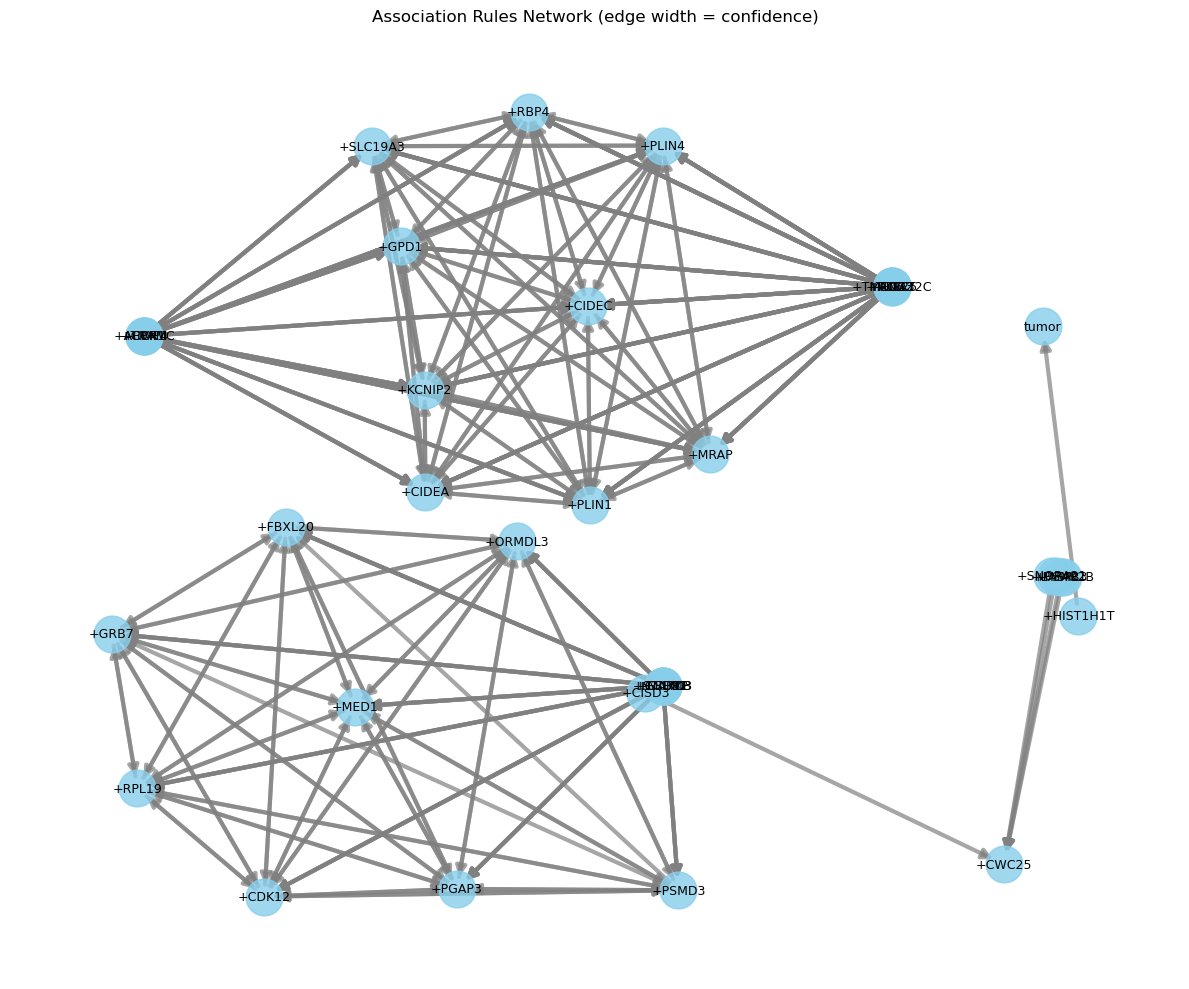

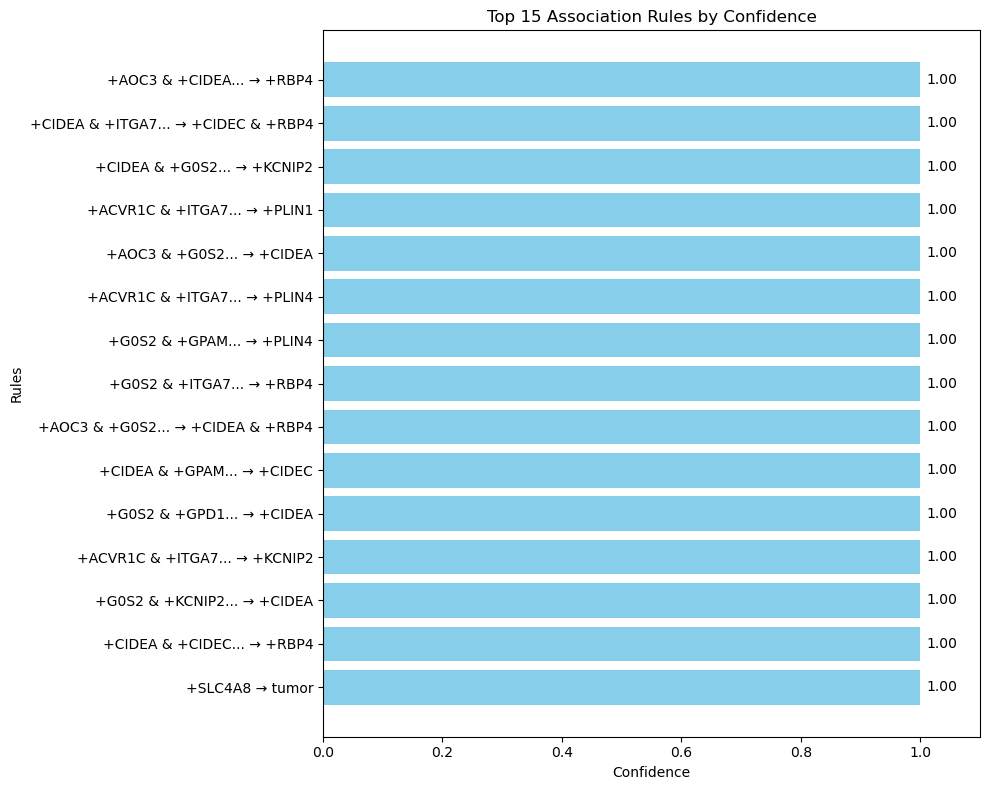

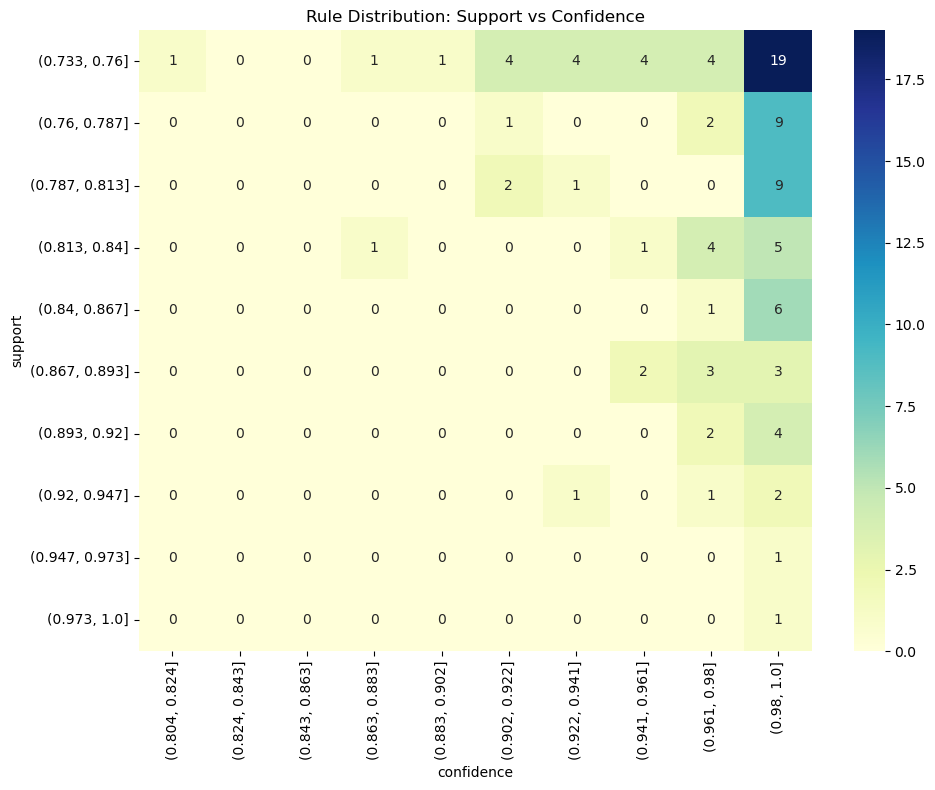

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Network visualization of top rules
def visualize_rule_network(rules_df, min_confidence=0.7, max_rules=10000):
    # Get top rules
    top_rules = rules_df.filter(F.col("confidence") >= min_confidence) \
                        .orderBy(F.col("confidence").desc()) \
                        .limit(max_rules) \
                        .toPandas()

    # Create graph
    G = nx.DiGraph()

    # Add edges from rules
    for _, row in top_rules.iterrows():
        for item_a in row['antecedent']:
            for item_c in row['consequent']:
                # Add edge with confidence as weight
                G.add_edge(item_a, item_c, weight=row['confidence'])

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    if len(G.nodes()) == 0:
        print("No rules meet the criteria. Try lowering min_confidence.")
        return

    # Set up plot
    plt.figure(figsize=(12, 10))

    # Choose layout based on graph size
    if len(G.nodes()) < 20:
        pos = nx.spring_layout(G, seed=42)
    else:
        pos = nx.kamada_kawai_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.8)

    # Draw edges with width based on confidence
    edge_widths = [G[u][v]['weight'] * 3 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7,
                          edge_color="gray", arrows=True, arrowsize=15)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title("Association Rules Network (edge width = confidence)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

# 2. Bar chart of top rules
def plot_top_rules_bar(rules_df, top_n=15):
    # Get top rules
    top_rules = rules_df.orderBy(F.col("confidence").desc()).limit(top_n).toPandas()

    # Create rule text (truncate if too long)
    def format_rule(row):
        ant = ' & '.join(row['antecedent'][:2])
        if len(row['antecedent']) > 2:
            ant += "..."

        cons = ' & '.join(row['consequent'][:2])
        if len(row['consequent']) > 2:
            cons += "..."

        return f"{ant} → {cons}"

    top_rules['rule_text'] = top_rules.apply(format_rule, axis=1)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = plt.barh(top_rules['rule_text'], top_rules['confidence'], color='skyblue')

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', ha='left', va='center')

    plt.xlabel('Confidence')
    plt.ylabel('Rules')
    plt.title(f'Top {top_n} Association Rules by Confidence')
    plt.xlim(0, 1.1)  # Confidence is between 0 and 1
    plt.tight_layout()
    plt.show()

# 3. Heatmap of support vs confidence
def plot_support_confidence_heatmap(rules_df, max_rules=100):
    # Calculate support from counts
    rules_with_support = rules_df.withColumn(
        "support",
        F.col("support_count_full_itemset") / F.lit(rules_df.select(F.max("support_count_antecedent")).collect()[0][0])
    )

    # Get data for heatmap
    heatmap_data = rules_with_support.select(
        "support", "confidence",
        F.size("antecedent").alias("antecedent_size"),
        F.size("consequent").alias("consequent_size")
    ).orderBy(F.col("support").desc()).limit(max_rules).toPandas()

    # Create pivot table
    pivot = pd.crosstab(
        pd.cut(heatmap_data['support'], bins=10),
        pd.cut(heatmap_data['confidence'], bins=10),
        values=heatmap_data['antecedent_size'],
        aggfunc='count'
    ).fillna(0)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='g')
    plt.title('Rule Distribution: Support vs Confidence')
    plt.tight_layout()
    plt.show()

# Example usage:
# 1. Network visualization
G = visualize_rule_network(association_rules_df, min_confidence=0.7)

# 2. Bar chart
plot_top_rules_bar(association_rules_df, top_n=15)

# 3. Heatmap
plot_support_confidence_heatmap(association_rules_df)

Found 3364 rules where consequent contains 'tumor' or 'normal'


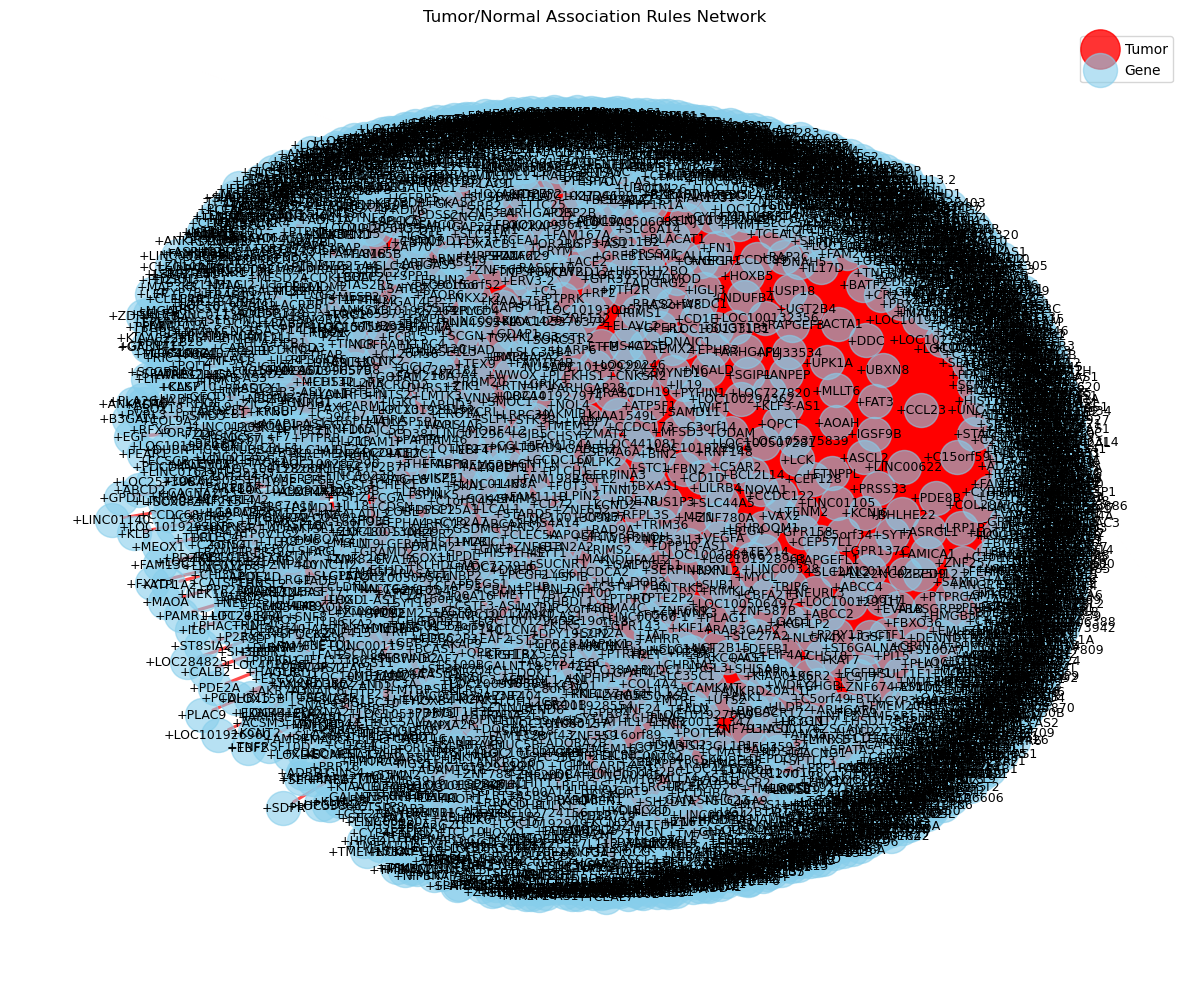

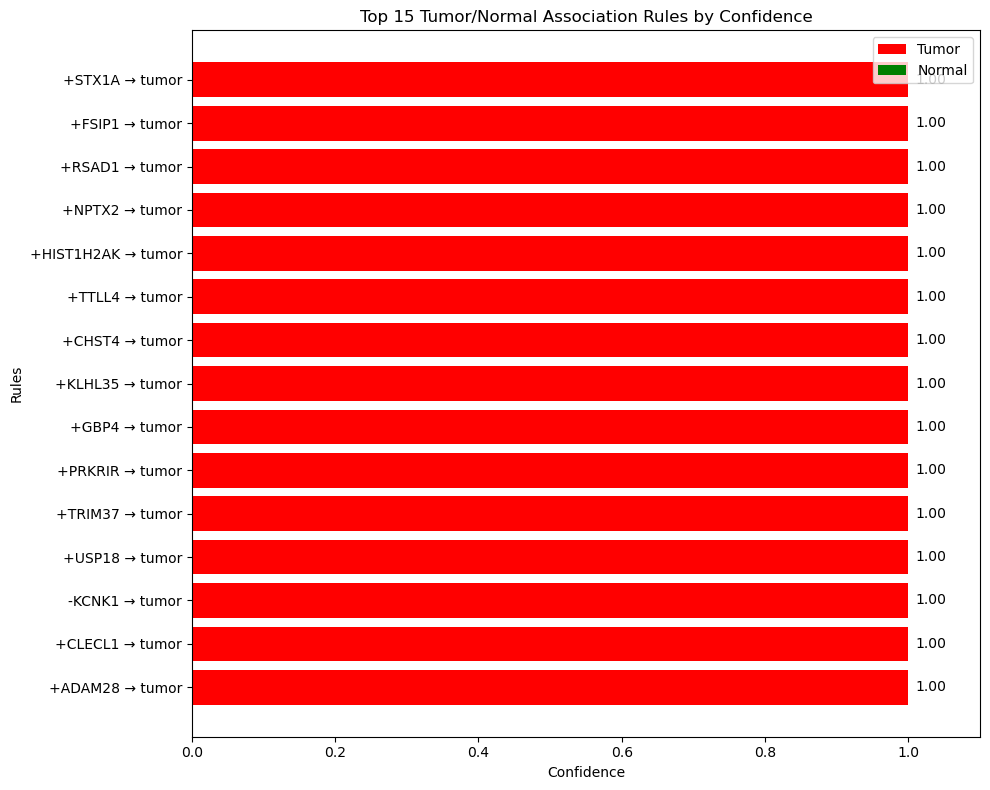

In [ ]:
# First, try the simple array_contains approach
tumor_normal_rules = association_rules_df.filter(
    F.array_contains(F.col("consequent"), "tumor") |
    F.array_contains(F.col("consequent"), "normal")
)

# Check how many such rules we have
count = tumor_normal_rules.count()
print(f"Found {count} rules where consequent contains 'tumor' or 'normal'")

# If we don't find any exact matches, try a different approach with explode and like
if count == 0:
    # Explode the consequent array and then filter with like
    tumor_normal_rules = association_rules_df.select("*", F.explode("consequent").alias("consequent_item")) \
        .filter(
            F.col("consequent_item").like("%tumor%") |
            F.col("consequent_item").like("%normal%")
        ) \
        .drop("consequent_item") \
        .distinct()

    count = tumor_normal_rules.count()
    print(f"Found {count} rules where consequent contains 'tumor' or 'normal' (partial match)")

# Now visualize these filtered rules
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Network visualization of tumor/normal rules
def visualize_tumor_normal_network(rules_df, min_confidence=0.5):
    # Convert to pandas
    rules_pd = rules_df.filter(F.col("confidence") >= min_confidence) \
                      .orderBy(F.col("confidence").desc()) \
                      .toPandas()

    if len(rules_pd) == 0:
        print("No rules meet the criteria. Try lowering min_confidence.")
        return None

    # Create graph
    G = nx.DiGraph()

    # Add edges from rules
    for _, row in rules_pd.iterrows():
        for item_a in row['antecedent']:
            for item_c in row['consequent']:
                # Add edge with confidence as weight
                is_tumor = 'tumor' in item_c.lower()
                is_normal = 'normal' in item_c.lower()

                if is_tumor or is_normal:
                    color = 'red' if is_tumor else 'green'
                    G.add_edge(item_a, item_c, weight=row['confidence'], color=color)

    if len(G.nodes()) == 0:
        print("No tumor/normal rules found in the filtered set.")
        return None

    # Set up plot
    plt.figure(figsize=(12, 10))

    # Position nodes
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw nodes with different colors for tumor/normal
    normal_nodes = [n for n in G.nodes() if 'normal' in n.lower()]
    tumor_nodes = [n for n in G.nodes() if 'tumor' in n.lower()]
    other_nodes = [n for n in G.nodes() if 'normal' not in n.lower() and 'tumor' not in n.lower()]

    nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_size=800,
                          node_color="green", alpha=0.8, label='Normal')
    nx.draw_networkx_nodes(G, pos, nodelist=tumor_nodes, node_size=800,
                          node_color="red", alpha=0.8, label='Tumor')
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_size=600,
                          node_color="skyblue", alpha=0.6, label='Gene')

    # Draw edges with colors based on target node
    edge_colors = [G[u][v].get('color', 'gray') for u, v in G.edges()]
    edge_widths = [G[u][v]['weight'] * 3 for u, v in G.edges()]

    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7,
                          edge_color=edge_colors, arrows=True, arrowsize=15)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title("Tumor/Normal Association Rules Network")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

# Bar chart of tumor/normal rules
def plot_tumor_normal_rules(rules_df, top_n=15):
    # Get top rules
    top_rules = rules_df.orderBy(F.col("confidence").desc()).limit(top_n).toPandas()

    if len(top_rules) == 0:
        print("No rules to display.")
        return

    # Create rule text
    def format_rule(row):
        ant = ' & '.join(row['antecedent'][:3])
        if len(row['antecedent']) > 3:
            ant += "..."

        cons = ' & '.join(row['consequent'])
        return f"{ant} → {cons}"

    top_rules['rule_text'] = top_rules.apply(format_rule, axis=1)

    # Determine color based on consequent
    def get_color(row):
        for item in row['consequent']:
            if 'tumor' in item.lower():
                return 'red'
            if 'normal' in item.lower():
                return 'green'
        return 'blue'

    top_rules['color'] = top_rules.apply(get_color, axis=1)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = plt.barh(top_rules['rule_text'], top_rules['confidence'], color=top_rules['color'])

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', ha='left', va='center')

    plt.xlabel('Confidence')
    plt.ylabel('Rules')
    plt.title(f'Top {top_n} Tumor/Normal Association Rules by Confidence')
    plt.xlim(0, 1.1)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Tumor'),
        Patch(facecolor='green', label='Normal')
    ]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

# Use the functions on filtered rules
if count > 0:
    visualize_tumor_normal_network(tumor_normal_rules, min_confidence=0.5)
    plot_tumor_normal_rules(tumor_normal_rules, top_n=15)
else:
    print("No tumor/normal rules found. Check if your data contains these terms.")